## Model Explained

This notebook is used evaluate the best model for the dataset, perform hyperparameter tuning and cross validation for our chosen model.

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# load dataset
df = pd.read_json('feature_eng_dataset.json')
X = df.loc[:, ~df.columns.isin(['Outcome', 'Home_Win'])]
y = df['Home_Win']

X = X.drop([
    'Season',
    'Elo_home_avg_3',
    'Elo_home_avg_10',
    'Elo_away_avg_3',
    'Elo_away_avg_10',
    'Home_Goals_avg_3',
    'Away_Goals_avg_3',
    'Home_Defence',
    'Away_Defence',
    'Home_Streak',
    'Away_Streak',
    'Home_Team_Outcome_sum_3',
    'Away_Team_Outcome_sum_3',
    'Home_Goals_avg_10',
    'Away_Goals_avg_10'   
    ], axis=1)

In [3]:
# split and standardise
def split_datasets(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [4]:
def compare_models(models, X_train, y_train, y_test):
    for model in models:
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        accu = accuracy_score(y_test, y_pred) * 100
        print(
            f"{model[0]}: "
            f"Accuracy: {accu:.2f}"
            )
    return

In [12]:
np.random.seed(2)

models = [
    ('lgr', make_pipeline(StandardScaler(), LogisticRegression())),
    ('rfc', RandomForestClassifier(max_depth=2)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
    ('dtc', DecisionTreeClassifier()),
    ('abc', AdaBoostClassifier()),
    ('gbc', GradientBoostingClassifier())
    ]

X_train, X_test, y_train, y_test = split_datasets(X, y)
compare_models(models, X_train, y_train, y_test)

lgr: Accuracy: 60.50
rfc: Accuracy: 58.46
knn: Accuracy: 56.42
dtc: Accuracy: 54.05
abc: Accuracy: 60.25
gbc: Accuracy: 60.55


### Hyperparameter Tuning

#### Hyperparameter tuning for Logistic Regression with Grid Search

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
model_1 = LogisticRegression()
params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

cv = KFold(n_splits=10, random_state=1, shuffle=True)
grid_search = GridSearchCV(model_1, params, scoring='accuracy', n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_result.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {grid_result.best_params_}')

    Best Score: 60.93%
    Best Hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}

#### Verfiy Grid Search with Random Search method

In [ ]:
from scipy.stats import uniform

distributions = dict(C=uniform(loc=0, scale=4),
                    penalty=['l2', 'l1'])

ran_search = RandomizedSearchCV(model_1, params, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
ran_result = ran_search.fit(X_train, y_train)
print(f'Best score: {ran_result.best_score_ * 100:.2f}%')
print(f'Best params: {ran_result.best_params_}')

    Best score: 60.88%
    Best params: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.001}

#### Hyperparameter tuning for Gradient Boosting 

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [18]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
min_split = [int(x) for x in np.linspace(start = 100, stop = 500, num = 4)]
max_depth = [int(x) for x in np.linspace(2, 32, num = 4)]
min_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 5)]
max_features = [int(x) for x in np.linspace(start = 7, stop = 10, num = 7)]

grid = {#'n_estimators': n_estimators,
#        'min_samples_split': min_split,
#        'max_depth': max_depth,
#        'min_samples_leaf': min_leaf,
#        'max_features': max_features,
#        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,1.0],
        }

model_2 = GradientBoostingClassifier(n_estimators= 130, learning_rate=0.1, max_depth=2, min_samples_split=100, max_features=7, subsample = 0.9)
grid_search = GridSearchCV(model_2, grid, cv = 3, verbose=2, n_jobs = -1)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_result.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {grid_result.best_params_}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=   8.8s
[CV] END .................................................... total time=   8.9s
[CV] END .................................................... total time=   9.3s
Best Score: 60.87%
Best Hyperparameters: {}


    Best Score: 60.87%

#### Assess feature importance from Gradient Boost model

Text(0, 0.5, 'Feature Importance Score')

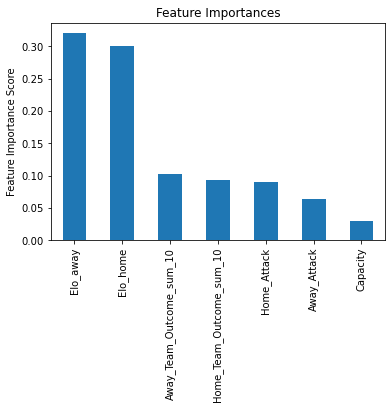

In [29]:
feat_imp = pd.Series(model_2.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Hyperparameter tuning for AdaBoost Classification

https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20 

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

def get_models():
	models = dict()
	# explore depths from 1 to 10
	for i in range(1,11):
		# define base model
		base = DecisionTreeClassifier(max_depth=i)
		# define ensemble model
		models[str(i)] = AdaBoostClassifier(n_estimators=150, base_estimator=base)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

In [17]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]

grid = {#'n_estimators': n_estimators,
#        'learning_rate': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0],
#        'algorithm': ['SAMME', 'SAMME.R']
        }

base = DecisionTreeClassifier(max_depth=1)
model_3 = AdaBoostClassifier(n_estimators=150, base_estimator=base)

grid_search = GridSearchCV(model_3, grid, cv = 3, verbose=2, n_jobs = -1)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_result.best_score_ * 100:.2f}%')
print(f'Best Hyperparameters: {grid_result.best_params_}')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ....................................algorithm=SAMME; total time=   7.5s
[CV] END ....................................algorithm=SAMME; total time=   8.0s
[CV] END ....................................algorithm=SAMME; total time=   9.9s
[CV] END ..................................algorithm=SAMME.R; total time=  10.7s
[CV] END ..................................algorithm=SAMME.R; total time=   7.6s
[CV] END ..................................algorithm=SAMME.R; total time=   7.5s
Best Score: 60.98%
Best Hyperparameters: {'algorithm': 'SAMME.R'}


    Best Score: 60.98%

### Model Evaluation

#### Confusion matrices and prediction probability:

The predicted class probabilities of an input sample is computed as the weighted mean predicted class probabilities of the classifiers in the ensemble.

In [45]:
def pred_proba_plot(clf, X, y, cv=5, no_bins=25, x_min=0.5, x_max=1, classifier=''):
    '''
    Histogram display of correcly predicted results against incorrectly given results given the outputed probability of the classifier.
    
    '''
    y_dup = []
    correct_guess_pred = []
    incorrect_guess_pred = []
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True)
    y_pred_cv = cross_val_predict(clf, X, y, cv=skf)
    y_pred_proba_cv = cross_val_predict(clf, X, y, cv=skf, method='predict_proba')
    y_dup.append(list(y))
    for i in range(len(y_pred_cv)):
        if y_pred_cv[i] == list(y)[i]:
            correct_guess_pred.append(max(y_pred_proba_cv[i]))
        if y_pred_cv[i] != list(y)[i]:
            incorrect_guess_pred.append(max(y_pred_proba_cv[i]))         
    
    bins = np.linspace(x_min, x_max, no_bins)
    fig, ax = plt.subplots()
    ax.hist(incorrect_guess_pred, bins, alpha=0.5, edgecolor='#1E212A', color='red', label='Incorrect Prediction')
    ax.hist(correct_guess_pred, bins, alpha=0.5, edgecolor='#1E212A', color='green', label='Correct Prediction')
    ax.legend()
    ax.set_title(f'{classifier}', y=1, fontsize=16, fontweight='bold');
    ax.set(ylabel='Number of Occurences',
            xlabel='Prediction Probability')
    return fig

In [46]:
def cross_val_confusion_matrix(clf, X, y, display_labels='', title='', cv=5):
    '''
    Function to plot confusion matrix given the result of cross-validation.
    '''
    
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    cm_norm = confusion_matrix(y, y_pred, normalize='true')
    fig = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=display_labels)
    fig.plot(cmap=plt.cm.Blues)
    fig.ax_.set_title(title)
    
    return fig

In [47]:
model_1 = LogisticRegression(solver='lbfgs', penalty='l2', C=0.001)
model_2 = GradientBoostingClassifier(n_estimators= 130, learning_rate=0.1, max_depth=2, min_samples_split=100, max_features=7, subsample = 0.9)
base = DecisionTreeClassifier(max_depth=1)
model_3 = AdaBoostClassifier(n_estimators=150, base_estimator=base)

In [ ]:
fig_lgr = pred_proba_plot(model_1, 
                            X, 
                            y,
                            no_bins=40,
                            x_min=0.5,
                            classifier='Logistic Regression')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

cross_val_confusion_matrix(model_1, X, y, 
                            display_labels=('other', 'win'), 
                            title='Logistic Regression Confusion Matrix', 
                            cv=skf)

#### Pairwise relationship plot with sns PairGrid

In [ ]:
import seaborn as sns

res = {-1: "Loss",
        1: "Victory",
        0: "Draw"}

df = df.replace({'Outcome':res})

grid = sns.PairGrid(df, hue="Outcome", palette='Set1', height=5)
grid.map_diag(sns.histplot)
grid.map_offdiag(sns.scatterplot)
grid.add_legend()

#### Cross validation:

Different cross validation techniques are used to see how they impact the output scores at each fold and to validate that the model is outputting consistent predictions (to satisfy the reliability of the model).

https://goldinlocks.github.io/Time-Series-Cross-Validation/

In [50]:
class BlockingTimeSeriesSplit():
    
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

cv_techniques = [
    ('K-Fold CV', KFold(n_splits=5, random_state=1, shuffle=True)),
    ('Time Series CV', TimeSeriesSplit(n_splits=10)),
    ('Blocking Time Series CV', BlockingTimeSeriesSplit(n_splits=10))
]

model_1 = LogisticRegression(solver='lbfgs', penalty='l2', C=0.001)
model_2 = GradientBoostingClassifier(n_estimators= 130, learning_rate=0.1, max_depth=2, min_samples_split=100, max_features=7, subsample = 0.9)
base = DecisionTreeClassifier(max_depth=1)
model_3 = AdaBoostClassifier(n_estimators=150, base_estimator=base)

for cvs in cv_techniques:

    accu = cross_val_score(model_2, X_train, y_train, cv=cvs[1], n_jobs=-1, scoring='accuracy')
    accu = [f'{a * 100:.2f}%' for a in accu]
    print(f'{cvs[0]}: {accu}')

K-Fold CV: ['61.63%', '61.16%', '60.89%', '60.80%', '60.48%']
Time Series CV: ['60.38%', '60.38%', '60.93%', '60.43%', '60.19%', '60.35%', '61.23%', '61.46%', '61.10%', '61.43%']
Blocking Time Series CV: ['60.46%', '57.63%', '61.70%', '57.00%', '59.90%', '61.63%', '60.04%', '61.97%', '60.80%', '61.42%']


### Significant difference:

As the accuracy scores for different models are similar, is it necessary to determine if there is significance difference between these results.

https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
https://www.maartengrootendorst.com/blog/validate/

    H0 = no significant difference between models
    H1 = significant difference between models

Wilcoxon signed-rank test: uses k accuracy scores of each model from k-fold cross-validation to test if the two samples differ significantly from each other. If p<0.05, reject the null hypothesis, H0. 

In [25]:
model_lgr = LogisticRegression(solver='lbfgs', penalty='l2', C=0.001)
model_gbc = GradientBoostingClassifier(n_estimators= 130, learning_rate=0.1, max_depth=2, min_samples_split=100, max_features=7, subsample = 0.9)
base = DecisionTreeClassifier(max_depth=1)
model_abc = AdaBoostClassifier(n_estimators=150, base_estimator=base)

In [27]:
from scipy.stats import wilcoxon

def wilcoxon_test(model_1, model_2):
    
    model_1.fit(X_train, y_train)
    model_2.fit(X_train, y_train)
    
    model_1_scores = cross_val_score(model_1, X_train, y_train, cv=cv_techniques[0][1], n_jobs=-1, scoring='accuracy')
    model_2_scores = cross_val_score(model_2, X_train, y_train, cv=cv_techniques[0][1], n_jobs=-1, scoring='accuracy')
    
    stat, p = wilcoxon(model_1_scores, model_2_scores, zero_method='zsplit')
    
    print(
        f"{model_1} vs {model_2}:",
        f"Wilcoxon test: {stat, p}"
        )
    return

In [29]:
wilcoxon_test(model_lgr, model_gbc)
wilcoxon_test(model_lgr, model_abc)
wilcoxon_test(model_gbc, model_abc)

LogisticRegression(C=0.001) vs GradientBoostingClassifier(max_depth=2, max_features=7, min_samples_split=100,
                           n_estimators=130, subsample=0.9) Wilcoxon test: (2.0, 0.1875)
LogisticRegression(C=0.001) vs AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=150) Wilcoxon test: (5.0, 0.625)
GradientBoostingClassifier(max_depth=2, max_features=7, min_samples_split=100,
                           n_estimators=130, subsample=0.9) vs AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=150) Wilcoxon test: (1.0, 0.125)


McNemar’s test: is a statistical test for paired nominal data. Specifically, it is used to compare the predictive accuracy of two models. McNemar's test is based on a 2x2 contingency table of the two model's predictions. From that table, we can calculate chi-squared (x²) which can be used to compute the p-value

In [42]:
import numpy as np
from mlxtend.evaluate import mcnemar_table, mcnemar

def mcnemar_test(model_1, model_2):
    
    model_1_predict = model_1.predict(X_test)
    model_2_predict = model_2.predict(X_test)
    
    tb = mcnemar_table(y_target = y_test, 
                        y_model1 = model_1_predict, 
                        y_model2 = model_2_predict)
    chi2, p = mcnemar(ary=tb, exact=True)
    
    print(f"{model_1} vs {model_2}:",
        f'{accuracy_score(y_test, model_1_predict) * 100:.2f}%',
        f'{accuracy_score(y_test, model_2_predict) * 100:.2f}%',
        f'chi-squared: {chi2}',
        f'p-value: {p}')
    
    return

In [44]:
mcnemar_test(model_lgr, model_gbc)
mcnemar_test(model_lgr, model_abc)
mcnemar_test(model_gbc, model_abc)

LogisticRegression(C=0.001) vs GradientBoostingClassifier(max_depth=2, max_features=7, min_samples_split=100,
                           n_estimators=130, subsample=0.9): 60.27% 60.21% chi-squared: 1818 p-value: 0.7659107154719285
LogisticRegression(C=0.001) vs AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=150): 60.27% 60.03% chi-squared: 1979 p-value: 0.2502882305859997
GradientBoostingClassifier(max_depth=2, max_features=7, min_samples_split=100,
                           n_estimators=130, subsample=0.9) vs AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=150): 60.21% 60.03% chi-squared: 967 p-value: 0.22595878362927932


combined 5x2CV F-test: procedure to compare the performance of two models. We assume a significance threshold of α=0.05 for rejecting the null hypothesis that both algorithms perform equally well on the dataset. 

In [39]:
from mlxtend.evaluate import combined_ftest_5x2cv

def f_test(model_1, model_2):
    
    t, p = combined_ftest_5x2cv(estimator1 = model_1,
                            estimator2 = model_2,
                            X = X_train, y = y_train,
                            random_seed=1)
    
    print(f"{model_1} vs {model_2}:",
        f't statistic: {t: .3f}',
        f'p value: %.3f {p: .3f}')
    
    return

In [41]:
f_test(model_lgr, model_gbc)
f_test(model_lgr, model_abc)
f_test(model_gbc, model_abc)

LogisticRegression(C=0.001) vs GradientBoostingClassifier(max_depth=2, max_features=7, min_samples_split=100,
                           n_estimators=130, subsample=0.9) t statistic:  4.827 p value: %.3f  0.048
LogisticRegression(C=0.001) vs AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=150) t statistic:  3.147 p value: %.3f  0.109
GradientBoostingClassifier(max_depth=2, max_features=7, min_samples_split=100,
                           n_estimators=130, subsample=0.9) vs AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=150) t statistic:  1.619 p value: %.3f  0.310


#### Statistical vs. Practical Significance

Statistical significance refers to the unlikelihood that mean differences observed in the sample have occurred due to sampling error. Given a large enough sample, despite seemingly insignificant population differences, one might still find statistical significance. 

Practical significance looks at whether the difference is large enough to be of value in a practical sense, this is more subjective.

https://towardsdatascience.com/comparing-machine-learning-models-statistical-vs-practical-significance-de345c38b42a

Large sample size: means small differences can be detected with a hypothesis test and therefore those tiny deviations could be perceived as significant.

mlxtend combined 5x2CV F-test takes in the full training set sample size (approx 7k samples) which is a very large sample. Therefore, while p<0.05 for the f-test, based on the other hypothesis testing and pratical significance we can make an intuitive decision that there is no significant difference between the models. 